In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decpomdp import DecPOMDP
import time
import random
import os
from constant import Constants
import gc 
gc.enable()


In [2]:
#set problem 
file_name = "2generals"
planning_horizon = 5
num_iterations = 1
sota_ = False
game_type = "zerosum"


problem = DecPOMDP(file_name,horizon=planning_horizon)
Constants.initialize(problem)
constant = Constants.get_instance()
from pbvi import PBVI
from experimentFunctions import Experiment
experiment = Experiment(planning_horizon,problem,algorithm="max_plane")
print(f"game size :\n\t|S| = {len(problem.states)} , {problem.states}")
print(f"\t|Z| = {problem.num_joint_observations} , {problem.joint_observations}\n\t|U|  with |U_i| = {problem.num_actions[0]}")
print(f"intiial_belief : {problem.b0}\nactions : {problem.joint_actions}")



game size :
	|S| = 2 , ['s_small', 's_large']
	|Z| = 4 , [('o_small', 'o_small'), ('o_small', 'o_large'), ('o_large', 'o_small'), ('o_large', 'o_large')]
	|U|  with |U_i| = 2
intiial_belief : [0.5 0.5]
actions : [('observe', 'observe'), ('observe', 'attack'), ('attack', 'observe'), ('attack', 'attack')]


In [3]:
#see reward matrix of both player
print(f"REWARD MATRIX OF {game_type} {problem.name} GAME")
print("\nLeader :")
print(f"{pd.DataFrame(constant.REWARDS[game_type][0],columns=problem.states)}")
print("\nFollower :")
print(f"{pd.DataFrame(constant.REWARDS[game_type][1],columns=problem.states)}")

r = constant.REWARDS[game_type][1]


REWARD MATRIX OF zerosum 2generals GAME

Leader :
   s_small  s_large
0     -1.0     -1.0
1    -10.0    -10.0
2    -10.0    -10.0
3      5.0    -20.0

Follower :
   s_small  s_large
0      1.0      1.0
1     10.0     10.0
2     10.0     10.0
3     -5.0     20.0


In [4]:
values,times ,tabular_value , policy= experiment.run_single_experiment(density=0.000001,gametype="stackelberg",limit=1000,sota=True,iterations=num_iterations)
values

			 Solving stackelberg 2generals GAME WITH SOTA True 5 
	belief expansion done, belief space size = 11

[{0}, {0, 1, 2}, {0, 1, 2, 3, 4}, {0, 1, 2, 3, 4, 5, 6}, {0, 1, 2, 3, 4, 5, 6, 7, 8}, {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}, set()]
[{0}, {0, 1, 2}, {0, 1, 2, 3, 4}, {0, 1, 2, 3, 4, 5, 6}, {0, 1, 2, 3, 4, 5, 6, 7, 8}, {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}, set()]
iteration : 1

========== Backup at timestep 4 done, verification done ==========

========== Backup at timestep 3 done, verification done ==========

========== Backup at timestep 2 done, verification done ==========


 FOUND DIFFERENCE during backuo of belief ID : 0 at timestep 1! 
Game stackelberg  :: 
	Reconstructed Max plane alpha:[array([ -2.27720325, -10.        ]), array([0., 3.])] , value =(-6.1386016244092625, 1.5)
	reconstructed tabular alpha : [array([ -3.17818318, -10.        ]), array([0., 3.])], value = (-6.589091590914461, 1.5)  --  belief [0.5 0.5]  -- DR <decisionRule.DecisionRule object at 0x14436fd90>

looking

[(-6.04971195077357, 1.5)]

In [5]:
database, matrix , policy= experiment.run_experiments(num_iterations,density=0.0000001)
pd.DataFrame(database)

			 Solving cooperative 2generals GAME WITH SOTA True 1 
	belief expansion done, belief space size = 3

[{0}, {0, 1, 2}, set()]
[{0}, {0, 1, 2}, set()]
iteration : 1

========== Backup at timestep 0 done, verification done ==========





================================================= END OF cooperative GAME WITH SOTA True ======================================================================

			point value at initial belief  (-1.0, -1.0)
			alphavectors value at inital belief (V0,V1) : (-1.0, -1.0)


			 Solving cooperative 2generals GAME WITH SOTA True 2 
	belief expansion done, belief space size = 5

[{0}, {0, 1, 2}, {0, 1, 2, 3, 4}, set()]
[{0}, {0, 1, 2}, {0, 1, 2, 3, 4}, set()]
iteration : 1

========== Backup at timestep 1 done, verification done ==========

========== Backup at timestep 0 done, verification done ==========





================================================= END OF cooperative GAME WITH SOTA True ===========================================================

,gametype,SOTA,horizon,iterations,time,number_of_beliefs,values,tabular value,density
0,cooperative,State of the Art,1,1,[0.002260923385620117],3,"[(-1.0, -1.0)]","[(-1.0, -1.0)]",1.000000e-07
1,cooperative,State of the Art,2,1,[0.004668712615966797],5,"[(0.32125000000000004, 0.32125000000000004)]","[(0.32125000000000004, 0.32125000000000004)]",1.000000e-07
2,cooperative,State of the Art,3,1,[0.010259866714477539],7,"[(0.019353125000000082, 0.019353125000000082)]","[(-0.034993749999999935, -0.034993749999999935)]",1.000000e-07
3,cooperative,State of the Art,4,1,[0.02063274383544922],9,"[(-0.22703861718750007, -0.22703861718750007)]","[(-0.38709215625000004, -0.38709215625000004)]",1.000000e-07
4,cooperative,State of the Art,5,1,[0.039689064025878906],11,"[(-0.4056927540429687, -0.4056927540429687)]","[(-0.737869234179688, -0.737869234179688)]",1.000000e-07
5,cooperative,Stackelberg,1,1,[0.027376174926757812],3,"[(-1.0, -1.0)]","[(-1.0, -1.0)]",1.000000e-07
6,cooperative,Stackelberg,2,1,[0.10472488403320312],5,"[(0.32125000000000004, 0.32125000000000004)]","[(0.32125000000000004, 0.32125000000000004)]",1.000000e-07
7,cooperative,Stackelberg,3,1,[0.2507929801940918],7,"[(0.019353125000000082, 0.019353125000000082)]","[(-0.034993749999999935, -0.034993749999999935)]",1.000000e-07
8,cooperative,Stackelberg,4,1,[0.42410707473754883],9,"[(-0.22703861718750007, -0.22703861718750007)]","[(-0.38709215625000004, -0.38709215625000004)]",1.000000e-07
9,cooperative,Stackelberg,5,1,[0.6653249263763428],11,"[(-0.4056927540429687, -0.4056927540429687)]","[(-0.737869234179688, -0.737869234179688)]",1.000000e-07


In [6]:
policy

{'cooperative': {True: [<policyTree.PolicyTree at 0x1055e3430>,
  False: [<policyTree.PolicyTree at 0x1445e8640>,
   <policyTree.PolicyTree at 0x1443d8460>]},
 'stackelberg': {True: [<policyTree.PolicyTree at 0x1055e2320>,
  False: [<policyTree.PolicyTree at 0x1443c4400>,
   <policyTree.PolicyTree at 0x1444f3b20>]},
 'zerosum': {True: [<policyTree.PolicyTree at 0x12772b220>,
  False: [<policyTree.PolicyTree at 0x1273c4e20>,
   <policyTree.PolicyTree at 0x1449695d0>]}}

/Users/izzikampono/Documents/GitHub/Thesis/experimentFunctions.py:183: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = self.database[self.database["gametype"]==gametype][self.database["horizon"]==self.planning_horizon]


TypeError: 'NoneType' object cannot be interpreted as an integer

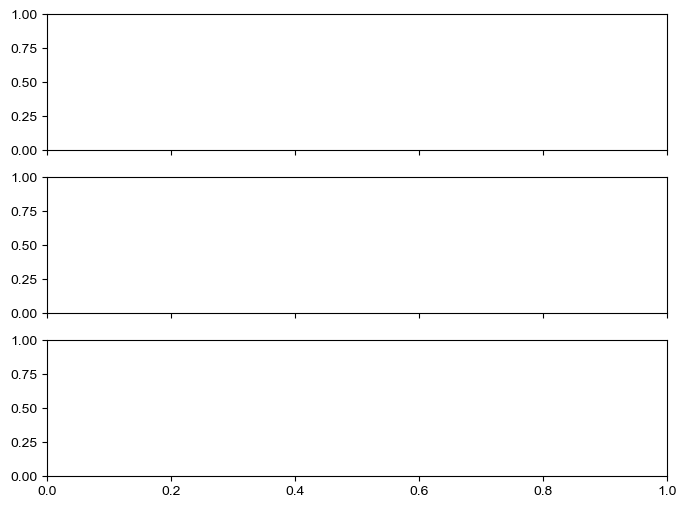

In [7]:
experiment.plots()
experiment.horizon_value_plot()

In [ ]:
experiment.generate_summary_table()

/Users/izzikampono/Documents/GitHub/Thesis/experimentFunctions.py:213: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_data = self.database[self.database["SOTA"]==SOTA][self.database["horizon"]==horizon+1][self.database["gametype"]==gametype]
/Users/izzikampono/Documents/GitHub/Thesis/experimentFunctions.py:213: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_data = self.database[self.database["SOTA"]==SOTA][self.database["horizon"]==horizon+1][self.database["gametype"]==gametype]
/Users/izzikampono/Documents/GitHub/Thesis/experimentFunctions.py:213: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_data = self.database[self.database["SOTA"]==SOTA][self.database["horizon"]==horizon+1][self.database["gametype"]==gametype]
/Users/izzikampono/Documents/GitHub/Thesis/experimentFunctions.py:213: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_

{'cooperative':           State of the Art                                                    \
                       time                                   value iteration   
 relay4(0)         0.933659  (7.409999999999998, 7.409999999999998)         3   
 relay4(1)         0.923161  (7.409999999999998, 7.409999999999998)         3   
 relay4(2)         0.922331  (7.409999999999998, 7.409999999999998)         3   
 relay4(3)         0.901461  (7.409999999999998, 7.409999999999998)         3   
 
                PBVI                                                    
                time                                   value iteration  
 relay4(0)  4.709343  (7.409999999999998, 7.409999999999998)         3  
 relay4(1)  4.689476  (7.409999999999998, 7.409999999999998)         3  
 relay4(2)  4.711464  (7.409999999999998, 7.409999999999998)         3  
 relay4(3)  4.664090  (7.409999999999998, 7.409999999999998)         3  ,
 'zerosum':           State of the Art                    